In [1]:
!pip install shap

In [2]:
!pip install lime

# Intuition to Isolation Forest

Isolation forest is a tree-based Anomaly detection technique. What makes it different from other algorithms is the fact that it looks for “Outliers” in the data as opposed to “Normal” points. Let’s take a two-dimensional space with the following points:

![](img/img_1.png)

We can see that the point at the extreme right is an outlier. The intuition behind the Isolation Forest is that outliers can be separated with smaller tree depths. Now, we know that tree-based methods tessellate the space into rectangles. Every line that breaks the space is a node in a decision tree. Let’s take an example. We tessellate the space and observe the number of tessellations needed to isolate the outlier:

![]('img/img_1.png')

![title](img/img_2.png)

Drawing lines randomly in order, we need 3 lines to separate the outlier. Let’s take another case:

![](img/img_3.png)

Here, you need only 2 lines to isolate the outlier. Now, let’s take the opposite case.

![](img/img_4.png)

Let’s say we want to isolate the point right in the middle. It’s can be seen that 4 lines are needed to do so. This gives us an intuition of how Isolation Forest works. The mathematics of this technique is beyond this article. For that, the reader may go through the original research paper [**here**](https://www.researchgate.net/publication/224384174_Isolation_Forest).

Having said that, let’s go through some code using [**Sensor Data**](https://www.kaggle.com/datasets/yungbyun/sensor-data) from Kaggle.

In [3]:
import lime
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## Step 1: Read the Data

In [4]:
df_sensor_data = pd.read_csv("./SensorData.csv")

## Step 2: Prepare the Data and Describe it

In this step, we separate the numerical values from  ID, Datetime, and Daytime. Furthermore, we describe the data using pandas describe.

In [5]:
y = df_sensor_data[['ID','Datetime','Daytime']].values
X = df_sensor_data.drop(['ID','Datetime','Daytime'],axis = 1)

X.describe()

,Temperature,Humidity,Pressure,Co2 Gas,PM2.5,PM10
count,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000
mean,25.495766,26.717673,972.445216,585.630732,31.674317,43.349195
std,1.544276,4.647934,2.133553,70.648084,117.932525,146.484405
min,22.877633,19.940209,971.496321,202.000000,3.400000,6.100000
25%,23.010362,23.672215,972.151132,536.000000,4.600000,9.500000
50%,26.313355,24.397101,972.418327,545.000000,4.900000,10.800000
75%,26.497142,33.548111,972.716458,629.000000,5.300000,12.400000
max,27.640713,43.001648,1107.566634,1015.000000,913.000000,1238.000000


This gives us some idea about the distribution of every variable that matters. In all the variables, there is a spike from 75th to 100th percentile. However, for a better judgment of the distribution, let’s zoom into data above the 75th percentile.

In [6]:
percentiles = np.linspace(0.76, 1, num=25, endpoint=True) #To generate an array of percentiles from 76(0.76) to 100(1.0)
X.quantile(percentiles)

,Temperature,Humidity,Pressure,Co2 Gas,PM2.5,PM10
0.76,26.497142,33.635612,972.725657,630.00,5.300,12.500
0.77,26.502247,33.760697,972.733536,630.00,5.400,12.600
0.78,26.507353,33.885608,972.738933,630.00,5.400,12.700
0.79,26.507353,33.996825,972.746291,631.00,5.500,12.800
0.80,26.517563,34.100606,972.753546,631.00,5.600,12.900
0.81,26.527773,34.136583,972.757172,631.00,5.600,13.100
0.82,26.532878,34.197606,972.761426,631.00,5.700,13.200
0.83,26.548194,34.271498,972.765678,632.00,5.800,13.400
0.84,26.558404,34.300625,972.769305,632.00,5.900,13.700
0.85,26.578825,34.340588,972.773557,632.00,6.200,14.000


This gives us an idea of the number of outliers that may exist in the data. From the looks of it, we can see that the columns PM2.5 and PM10 (Air Quality Index) have a significant number of outliers. A simple google search will reveal that PM2.5 > 150 is harmful, while PM10>80 is serious. Hence, approximately 15 percent of values are outlier candidates. This sets us for using an Anomaly Detection algorithm like Isolation forest.

## Step 3: Train an Isolation Forest model

In [7]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(max_samples='auto',bootstrap=False, n_jobs=-1, random_state=42)

iforest_= iforest.fit(X)

y_pred = iforest_.predict(X)

Further, we calculate the Anomaly Score using the decision_function() method of iforest. A positive score shows a normal point, whereas a negative score represents an Anomalous point.

In [8]:
y_score = iforest.decision_function(X)

From the scores, we can find the points that have been predicted/marked as anomalous:

In [9]:
neg_value_indices = np.where(y_score<0)
len(neg_value_indices[0])

574

The length of the array is 574. That means there are 574 anomalous points, which is 14 percent of 4100. This is in line with our estimate that around 15 per cent of data points could be anomalous.

## Step 4: Machine Learning Interpretability

From the previous article on Machine Learning Interpretability, we know SHAP can give global and local interpretability. Moreover, we saw SHAP has a specialized explainer for Tree-based models viz. *TreeExplainer*. Since Isolation Forest is tree-based, let’s follow similar steps here:

### A Tree Explainer

First, create an explainer object and use that to calculate SHAP values.

In [10]:
exp = shap.TreeExplainer(iforest) #Explainer
shap_values = exp.shap_values(X)  #Calculate SHAP values
shap.initjs()

### Global Machine Learning Interpretability

The next step is creating a summary plot. Summary plots help us visualize the global importance of features.

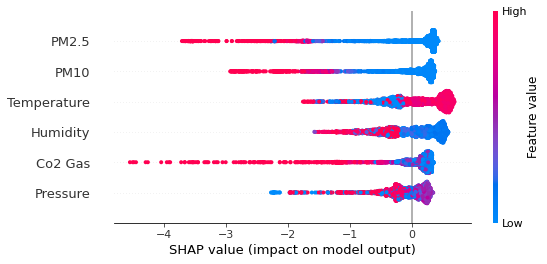

In [11]:
shap.summary_plot(shap_values, X)

This plot gives us the impact of a particular variable on anomaly detection. Let’s take Co2 as an example. The summary plot says that high values of  Co2 show anomalous items while lower values are normal items.

A more comprehensive way to visualize the summary plot is as a bar plot.

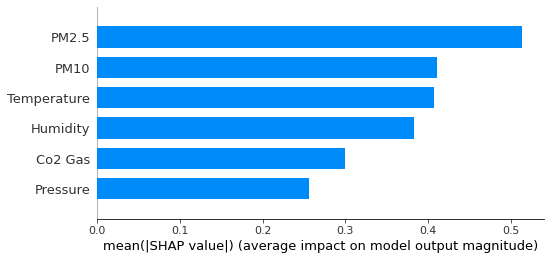

In [12]:
shap.summary_plot(shap_values, X,plot_type="bar")

Evidently, the variables PM2.5 and PM10 have the highest average SHAP value. Hence, they have the highest impact on determining the anomaly score. This corroborates our observations while exploring the descriptive statistics of the data.

Having said that, let’s explain the predictions for a single instance.

### Local Machine Learning Interpretability

The beauty of local interpretability is that it gives explanations for a particular point, which may differ from global explanations. Let’s take an example. One of the indices in *neg_value_indices*, i.e. the indices of anomalous points, was found to be 1041. Let’s explain this instance using a force plot and a bar plot.

A force plot is a visual that shows the influence of feature(s) on the predictions.

In [13]:
shap.force_plot(exp.expected_value, shap_values[1041],features =X.iloc[1041,:] ,feature_names =X.columns)

In this example,  Co2 and Humidity are pushing the outcome towards being an anomaly. Again, a better way to see local explanations is a bar plot.

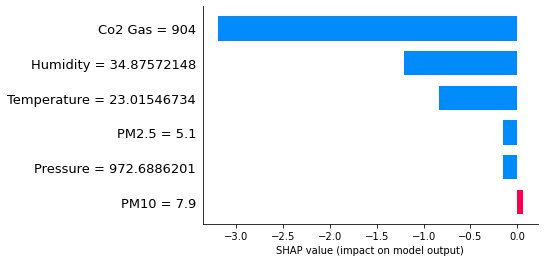

In [14]:
shap.bar_plot(shap_values[1041],features =X.iloc[1041,:] ,feature_names =X.columns )

It is clear from the above plot that high Co2 and Humidity show anomalous behaviour. Moreover, PM2.5 and PM10 are not out of bound. Hence, this point does not follow the global trend where the two aforementioned variables are primary determinants of anomaly.